In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
import kaggle


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download bhaveshmittal/melanoma-cancer-dataset

Dataset URL: https://www.kaggle.com/datasets/bhaveshmittal/melanoma-cancer-dataset
License(s): CC0-1.0
 96% 76.0M/79.4M [00:01<00:00, 74.2MB/s]
100% 79.4M/79.4M [00:01<00:00, 78.1MB/s]


In [ ]:
!unzip melanoma-cancer-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/Malignant/1530.jpg  
  inflating: train/Malignant/1531.jpg  
  inflating: train/Malignant/1532.jpg  
  inflating: train/Malignant/1533.jpg  
  inflating: train/Malignant/1534.jpg  
  inflating: train/Malignant/1535.jpg  
  inflating: train/Malignant/1536.jpg  
  inflating: train/Malignant/1537.jpg  
  inflating: train/Malignant/1538.jpg  
  inflating: train/Malignant/1539.jpg  
  inflating: train/Malignant/154.jpg  
  inflating: train/Malignant/1540.jpg  
  inflating: train/Malignant/1541.jpg  
  inflating: train/Malignant/1542.jpg  
  inflating: train/Malignant/1543.jpg  
  inflating: train/Malignant/1544.jpg  
  inflating: train/Malignant/1545.jpg  
  inflating: train/Malignant/1546.jpg  
  inflating: train/Malignant/1547.jpg  
  inflating: train/Malignant/1548.jpg  
  inflating: train/Malignant/1549.jpg  
  inflating: train/Malignant/155.jpg  
  inflating: train/Malignant/1550.jpg  
  inflating: train/Malignant/15

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import tensorflow as tf
import keras


In [ ]:
train_path = "/content/train"

In [ ]:
batch_size = 64
img_height = 224
img_width = 224

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split = 0.2,
    subset = "training",
    seed = 100,
    image_size = (img_height, img_width),
    batch_size = batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split = 0.2,
    subset = "validation",
    seed = 100,
    image_size = (img_height, img_width),
    batch_size = batch_size
)


Found 11879 files belonging to 2 classes.
Using 9504 files for training.
Found 11879 files belonging to 2 classes.
Using 2375 files for validation.


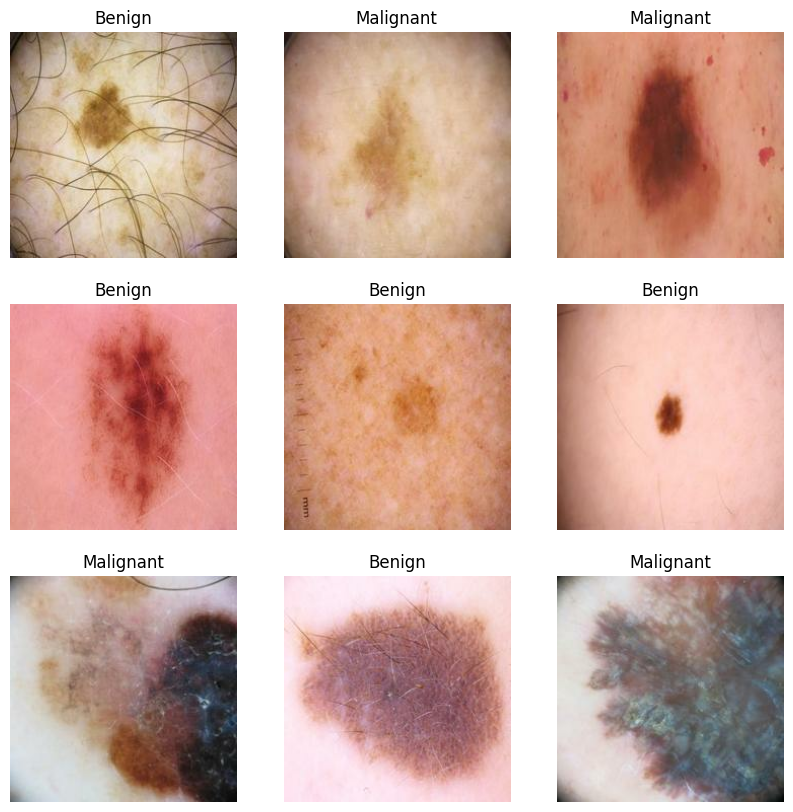

In [ ]:
class_names = train_ds.class_names
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [ ]:
augmentation_layers = [
    keras.layers.RandomRotation(factor=0.30),
    keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    keras.layers.RandomFlip(),
    keras.layers.RandomContrast(factor=0.1),
    keras.layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
    keras.layers.RandomBrightness(factor=(-0.1, 0.1))
]



def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

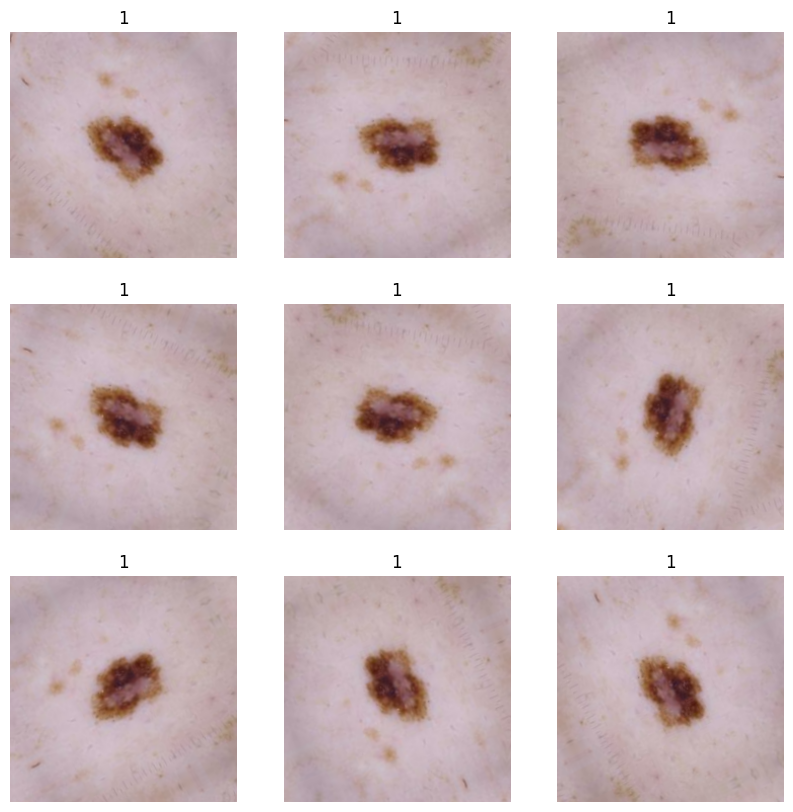

In [ ]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")


In [ ]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)
base_model.trainable = False
inputs = keras.Input(shape=(224, 224, 3))
scale_layer = keras.layers.Rescaling(scale = 1/127.5, offset = -1)
x = scale_layer(inputs)
x = base_model(x, training = False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1, activation = 'sigmoid')(x)
model = keras.Model(inputs, outputs)
model.summary(show_trainable = True)

83683744/83683744 [==============================] - 2s 0us/step
Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 224, 224, 3)       0         Y          
                                                                            
 xception (Functional)       (None, 7, 7, 2048)        2086148   N          
                                                       0                    
                                                                            
 global_average_pooling2d (  (None, 2048)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                                         

In [ ]:
model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.BinaryCrossentropy(),
    metrics = [keras.metrics.BinaryAccuracy()]
)

In [ ]:
epochs = 3
model.fit(train_ds, epochs = epochs, validation_data = val_ds)

Epoch 1/3
149/149 [==============================] - 210s 1s/step - loss: 0.4903 - binary_accuracy: 0.7632 - val_loss: 0.3780 - val_binary_accuracy: 0.8316
Epoch 2/3
149/149 [==============================] - 185s 1s/step - loss: 0.4155 - binary_accuracy: 0.8114 - val_loss: 0.3524 - val_binary_accuracy: 0.8493
Epoch 3/3
149/149 [==============================] - 183s 1s/step - loss: 0.3962 - binary_accuracy: 0.8218 - val_loss: 0.3415 - val_binary_accuracy: 0.8505


In [ ]:
model.save_weights("sig_xcep_features.weights.h5")

In [ ]:
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()],
)



Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 224, 224, 3)       0         Y          
                                                                            
 xception (Functional)       (None, 7, 7, 2048)        2086148   Y          
                                                       0                    
                                                                            
 global_average_pooling2d (  (None, 2048)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dropout (Dropout)           (None, 2048)              0     

In [ ]:
epochs = 1

model.fit(train_ds, epochs=epochs, validation_data=val_ds)

In [ ]:
model.save_weights("sigXception_finetune.weights.h5")

In [ ]:
model.load_weights("sigXception_finetune.weights.h5")

In [ ]:
predictions = model.predict(val_ds)

38/38 [==============================] - 12s 285ms/step


In [ ]:
np.round(predictions)

array([[0.],
       [0.],
       [1.],
       ...,
       [1.],
       [0.],
       [1.]], dtype=float32)

In [ ]:
test_path = "/content/test"

In [ ]:
test_ds = keras.utils.image_dataset_from_directory(
    test_path,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 2000 files belonging to 2 classes.


In [ ]:
test_labels = np.array([])
test_pred_manual = np.array([])
for image, label in test_ds:
    test_labels = np.append(test_labels, label)
    test_pred_manual = np.append(test_pred_manual, model.predict(image))


test_labels

1/1 [==============================] - 0s 27ms/step


array([0., 1., 1., ..., 0., 0., 1.])

In [ ]:
len(test_labels)

2000

In [ ]:
test_pred_manual

array([0.04914466, 0.93696916, 0.87699437, ..., 0.13440919, 0.33747804,
       0.89869374])

In [ ]:
np.round(test_pred_manual)

array([0., 1., 1., ..., 0., 0., 1.])

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(test_labels, np.round(test_pred_manual))

0.8835

In [ ]:
test_conf_mat = confusion_matrix(test_labels, np.round(test_pred_manual))

In [ ]:
print(test_conf_mat)

[[937  63]
 [170 830]]


In [ ]:
model.evaluate(test_ds)

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


32/32 [==============================] - 14s 287ms/step - loss: 0.2967 - binary_accuracy: 0.8835 - auc_1: 0.9547


[0.2967250943183899, 0.8834999799728394, 0.9546825289726257]

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


In [ ]:
fpr_xcep, tpr_xcep, thresh_xcep = roc_curve(test_labels, test_pred_manual)


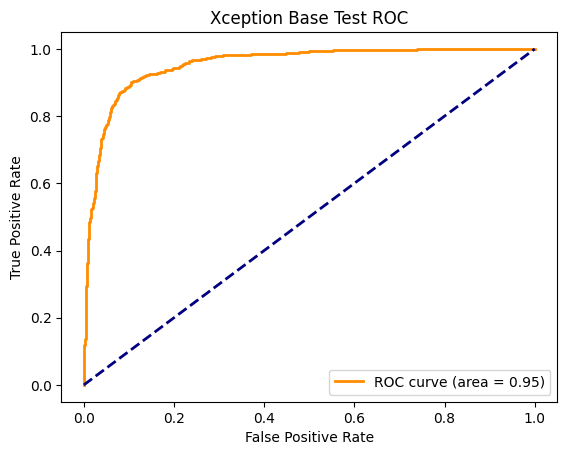

In [ ]:
roc_auc = auc(fpr_xcep, tpr_xcep)
plt.figure()
plt.plot(fpr_xcep, tpr_xcep, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Xception Base Test ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
val_preds = np.array([])
val_labs = np.array([])
for image, label in val_ds:
  np.append(val_labs, label)
  np.append(val_preds, model.predict(image))


1/1 [==============================] - 0s 24ms/step


array([], dtype=float64)

In [ ]:
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

In [ ]:
recall_score(test_labels, np.round(test_pred_manual))

0.83

In [ ]:
def calculate_recall_at_threshold(y_true, y_prob, threshold):
    y_pred = (y_prob >= threshold).astype(int)
    recall = recall_score(y_true, y_pred)
    return recall

def calculate_accuracy_at_threshold(y_true, y_prob, threshold):
    y_pred = (y_prob >= threshold).astype(int)
    accuracy = accuracy_score(y_true, y_pred)
    return accuracy

def calculate_spec_at_threshold(y_true, y_prob, threshold):
    y_pred = (y_prob >= threshold).astype(int)
    recall = recall_score(y_true, y_pred, pos_label = 0)
    return recall

In [ ]:
calculate_accuracy_at_threshold(test_labels, test_pred_manual, 0.4)

0.8945

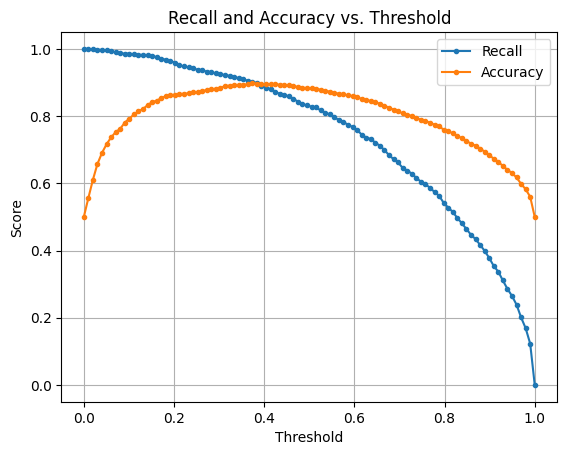

In [ ]:
thresholds = np.linspace(0, 1, 100)

# Calculate recall for each threshold
recalls = [calculate_recall_at_threshold(test_labels, test_pred_manual, threshold) for threshold in thresholds]
accuracies = [calculate_accuracy_at_threshold(test_labels, test_pred_manual, threshold) for threshold in thresholds]

# Plot recall and accuracy vs. threshold
# Plot recall vs. threshold
plt.plot(thresholds, recalls, marker='.', label='Recall')
plt.plot(thresholds, accuracies, marker='.', label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Score')

plt.title('Recall and Accuracy vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
full_ds = keras.utils.image_dataset_from_directory(
    train_path,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 11879 files belonging to 2 classes.


In [ ]:
train_labs = np.array([])
train_preds = np.array([])
for image, label in full_ds:
  train_labs = np.append(train_labs, label)
  train_preds = np.append(train_preds, model.predict(image))

2/2 [==============================] - 4s 2s/step


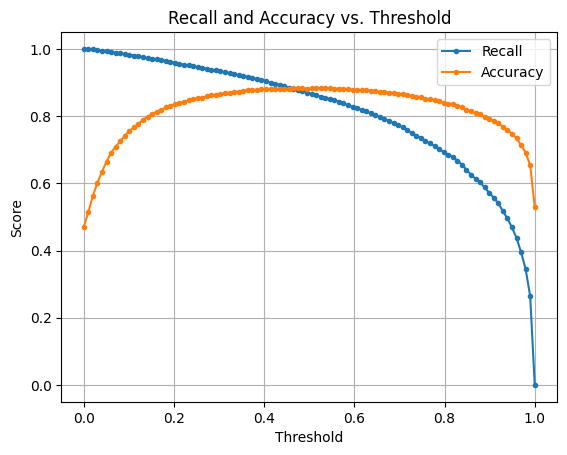

In [ ]:
recalls = [calculate_recall_at_threshold(train_labs, train_preds, threshold) for threshold in thresholds]
accuracies = [calculate_accuracy_at_threshold(train_labs, train_preds, threshold) for threshold in thresholds]

# Plot recall and accuracy vs. threshold
# Plot recall vs. threshold
plt.plot(thresholds, recalls, marker='.', label='Recall')
plt.plot(thresholds, accuracies, marker='.', label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Score')

plt.title('Recall and Accuracy vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
threshold_vec = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
recalls_at = np.array([])
accuracy_at = np.array([])
specificity_at = np.array([])
for i in threshold_vec:
  recalls_at = np.append(recalls_at, calculate_recall_at_threshold(train_labs, train_preds, i))
  accuracy_at = np.append(accuracy_at, calculate_accuracy_at_threshold(train_labs, train_preds, i))
  specificity_at = np.append(specificity_at, calculate_spec_at_threshold(train_labs, train_preds, i))

In [ ]:
threshold_vec

array([0.1, 0.2, 0.3, 0.4, 0.5])

In [ ]:
recalls_at

array([0.98246869, 0.95974955, 0.93416816, 0.90518784, 0.86762075])

In [ ]:
specificity_at

array([0.55159803, 0.72332644, 0.80442042, 0.85832406, 0.89441883])

In [ ]:
accuracy_at

array([0.75435643, 0.83458204, 0.86547689, 0.88037714, 0.88180823])